Downloading dataset and splitting it into train , test and validation folders

In [1]:
import matplotlib.pyplot as plt
import os
import zipfile
try:
    import gdown
except ImportError:
    !pip install gdown

def download_dataset_from_google_drive(google_file_id: str, output_file_name: str, quiet_download: bool) -> str:
    file_path = f'./{output_file_name}'

    if not os.path.exists(file_path):
        gdown.download(id=google_file_id, output=output_file_name, quiet=quiet_download)
    else:
        print(f"{output_file_name} already exists!")
    if os.path.exists(file_path):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('./')
    return file_path

# https://drive.google.com/file/d/1ri_BeyDpe_eGy-WRFqQ-yGiUcvnEl4Ah/view?usp=sharing
data_path = "1ri_BeyDpe_eGy-WRFqQ-yGiUcvnEl4Ah"

In [2]:
data_dir = download_dataset_from_google_drive(data_path, "data.zip", True)

# Building the CNN Architecture
1. <b>Rescaling Layer</b> – Normalizes pixel values from [0, 255] to [0, 1] for stable training.
2. <b>Convolutional Layers (3×3 filters)</b> – Extracts hierarchical features using varying filter sizes with the ReLU activation function.
3. <b>MaxPooling Layer (2×2)</b> – Reduces spatial dimensions while preserving dominant features
4. <b>Global Average Pooling</b> – Aggregates all values to get an average value.
5. <b>Dense Layer</b> – Applies sigmoid function to the value for classification purposes

In [6]:
import keras
from keras import layers
inputs = keras.Input(shape=(180, 180, 3))     #1
x = layers.Rescaling(1./255)(inputs)         #2
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)  #3
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

Defining Loss function and weight updation strategy

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [16]:
from keras.utils import image_dataset_from_directory
batch_size = 64
image_size = (180, 180)
train_dataset = image_dataset_from_directory(
    "./cats_vs_dogs/train/",
    image_size=image_size,
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    "./cats_vs_dogs/validation/",
    image_size=image_size,
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 942ms/step - accuracy: 0.4909 - loss: 0.7108 - val_accuracy: 0.5160 - val_loss: 0.6929
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 899ms/step - accuracy: 0.5189 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - accuracy: 0.5164 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 818ms/step - accuracy: 0.4980 - loss: 0.6930 - val_accuracy: 0.5960 - val_loss: 0.6716
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 772ms/step - accuracy: 0.5388 - loss: 0.6882 - val_accuracy: 0.5900 - val_loss: 0.6735
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 774ms/step - accuracy: 0.5894 - loss: 0.6757 - val_accuracy: 0.6190 - val_loss: 0.6619
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 799ms/step - accuracy: 0.5987 - loss: 0.6620 - val_accuracy: 0.5560 - val_loss: 0.6713
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 763ms/step - accuracy: 0.5644 - loss: 0.6710 - val_accu

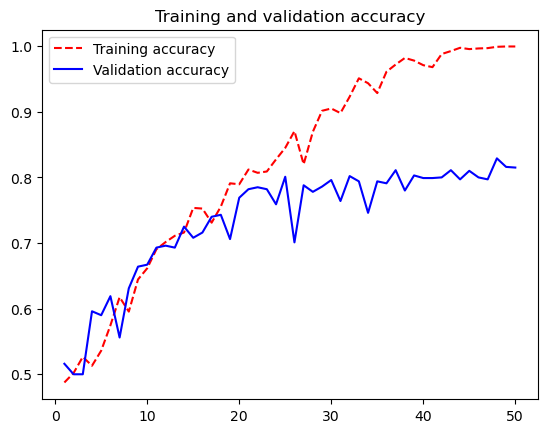

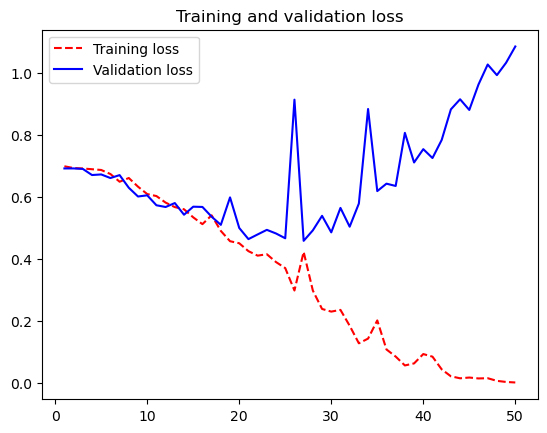

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()